In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [2]:
class Perceptron(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (28, 28),
                 input_channels: int = 1, 
                 hidden_layer_features: List[int] = [256, 256],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super().__init__()

        network_layers = []
        in_features = np.product(input_resolution) * input_channels

        for out_features in hidden_layer_features:
            network_layers.append(torch.nn.Linear(in_features, out_features))
            network_layers.append(activation())
            in_features = out_features
            
        network_layers.append(torch.nn.Linear(in_features, num_classes))
        self._layers = torch.nn.Sequential(*network_layers)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self._layers.forward(x)

In [3]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader,
                       tb_writer: SummaryWriter,
                       epoch: int,
                       batch_size: int):
    train_loss = []
    batch_averaged_loss = []
    model.train()
    for idx,(batch_data, batch_labels) in tqdm(enumerate(data_loader), total=len(data_loader)):
        optimizer.zero_grad()
#         data_gpu, labels_gpu = batch_data.cuda(), batch_labels.cuda()
        data_gpu, labels_gpu = batch_data, batch_labels
        output = model(data_gpu)
        loss = loss_function(output, labels_gpu)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss.append(loss.item())
        batch_averaged_loss.append(loss.item())
        if idx % 20 == 0:
            batch_averaged_loss_ = np.sum(batch_averaged_loss)/len(batch_averaged_loss)
            tb_writer.add_scalar('train_batch_loss', batch_averaged_loss_, global_step = epoch*(int(len(data_loader.dataset)/batch_size))+idx)
    
    for tag, param in model.named_parameters():
        tb_writer.add_histogram('grad/%s'%tag, param.grad.data.cpu().numpy(), epoch)
        tb_writer.add_histogram('weight/%s' % tag, param.data.cpu().numpy(), epoch)
    
    return train_loss

In [4]:
def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, labels in tqdm(data_loader, total=len(data_loader)):
#             data_gpu, labels_gpu = data.cuda(), labels.cuda()
            data_gpu, labels_gpu = data, labels
            output = model(data_gpu)
            test_loss += loss_function(output, labels_gpu).sum()
            
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels_gpu.view_as(pred)).sum()

    return {'loss': test_loss.item() / len(data_loader.dataset),
            'accuracy': correct.cpu().numpy() / len(data_loader.dataset)}

In [5]:
model = Perceptron(hidden_layer_features=[512, 256, 128, 32], activation=torch.nn.GELU, num_classes=10)
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

Perceptron(
  (_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): GELU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): GELU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): GELU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): GELU()
    (8): Linear(in_features=32, out_features=10, bias=True)
  )
)
Total number of trainable parameters 570602


In [43]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(28, 28), scale=(.5, 1.0), ratio=(.8, 1.25)),
    torchvision.transforms.RandomRotation(degrees=30),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [44]:
train_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                           train=True, 
                                           download=True,
                                           transform=train_transforms)

val_dataset = torchvision.datasets.MNIST(root='./mnist', 
                                         train=False, 
                                         download=True, 
                                         transform=val_transforms)

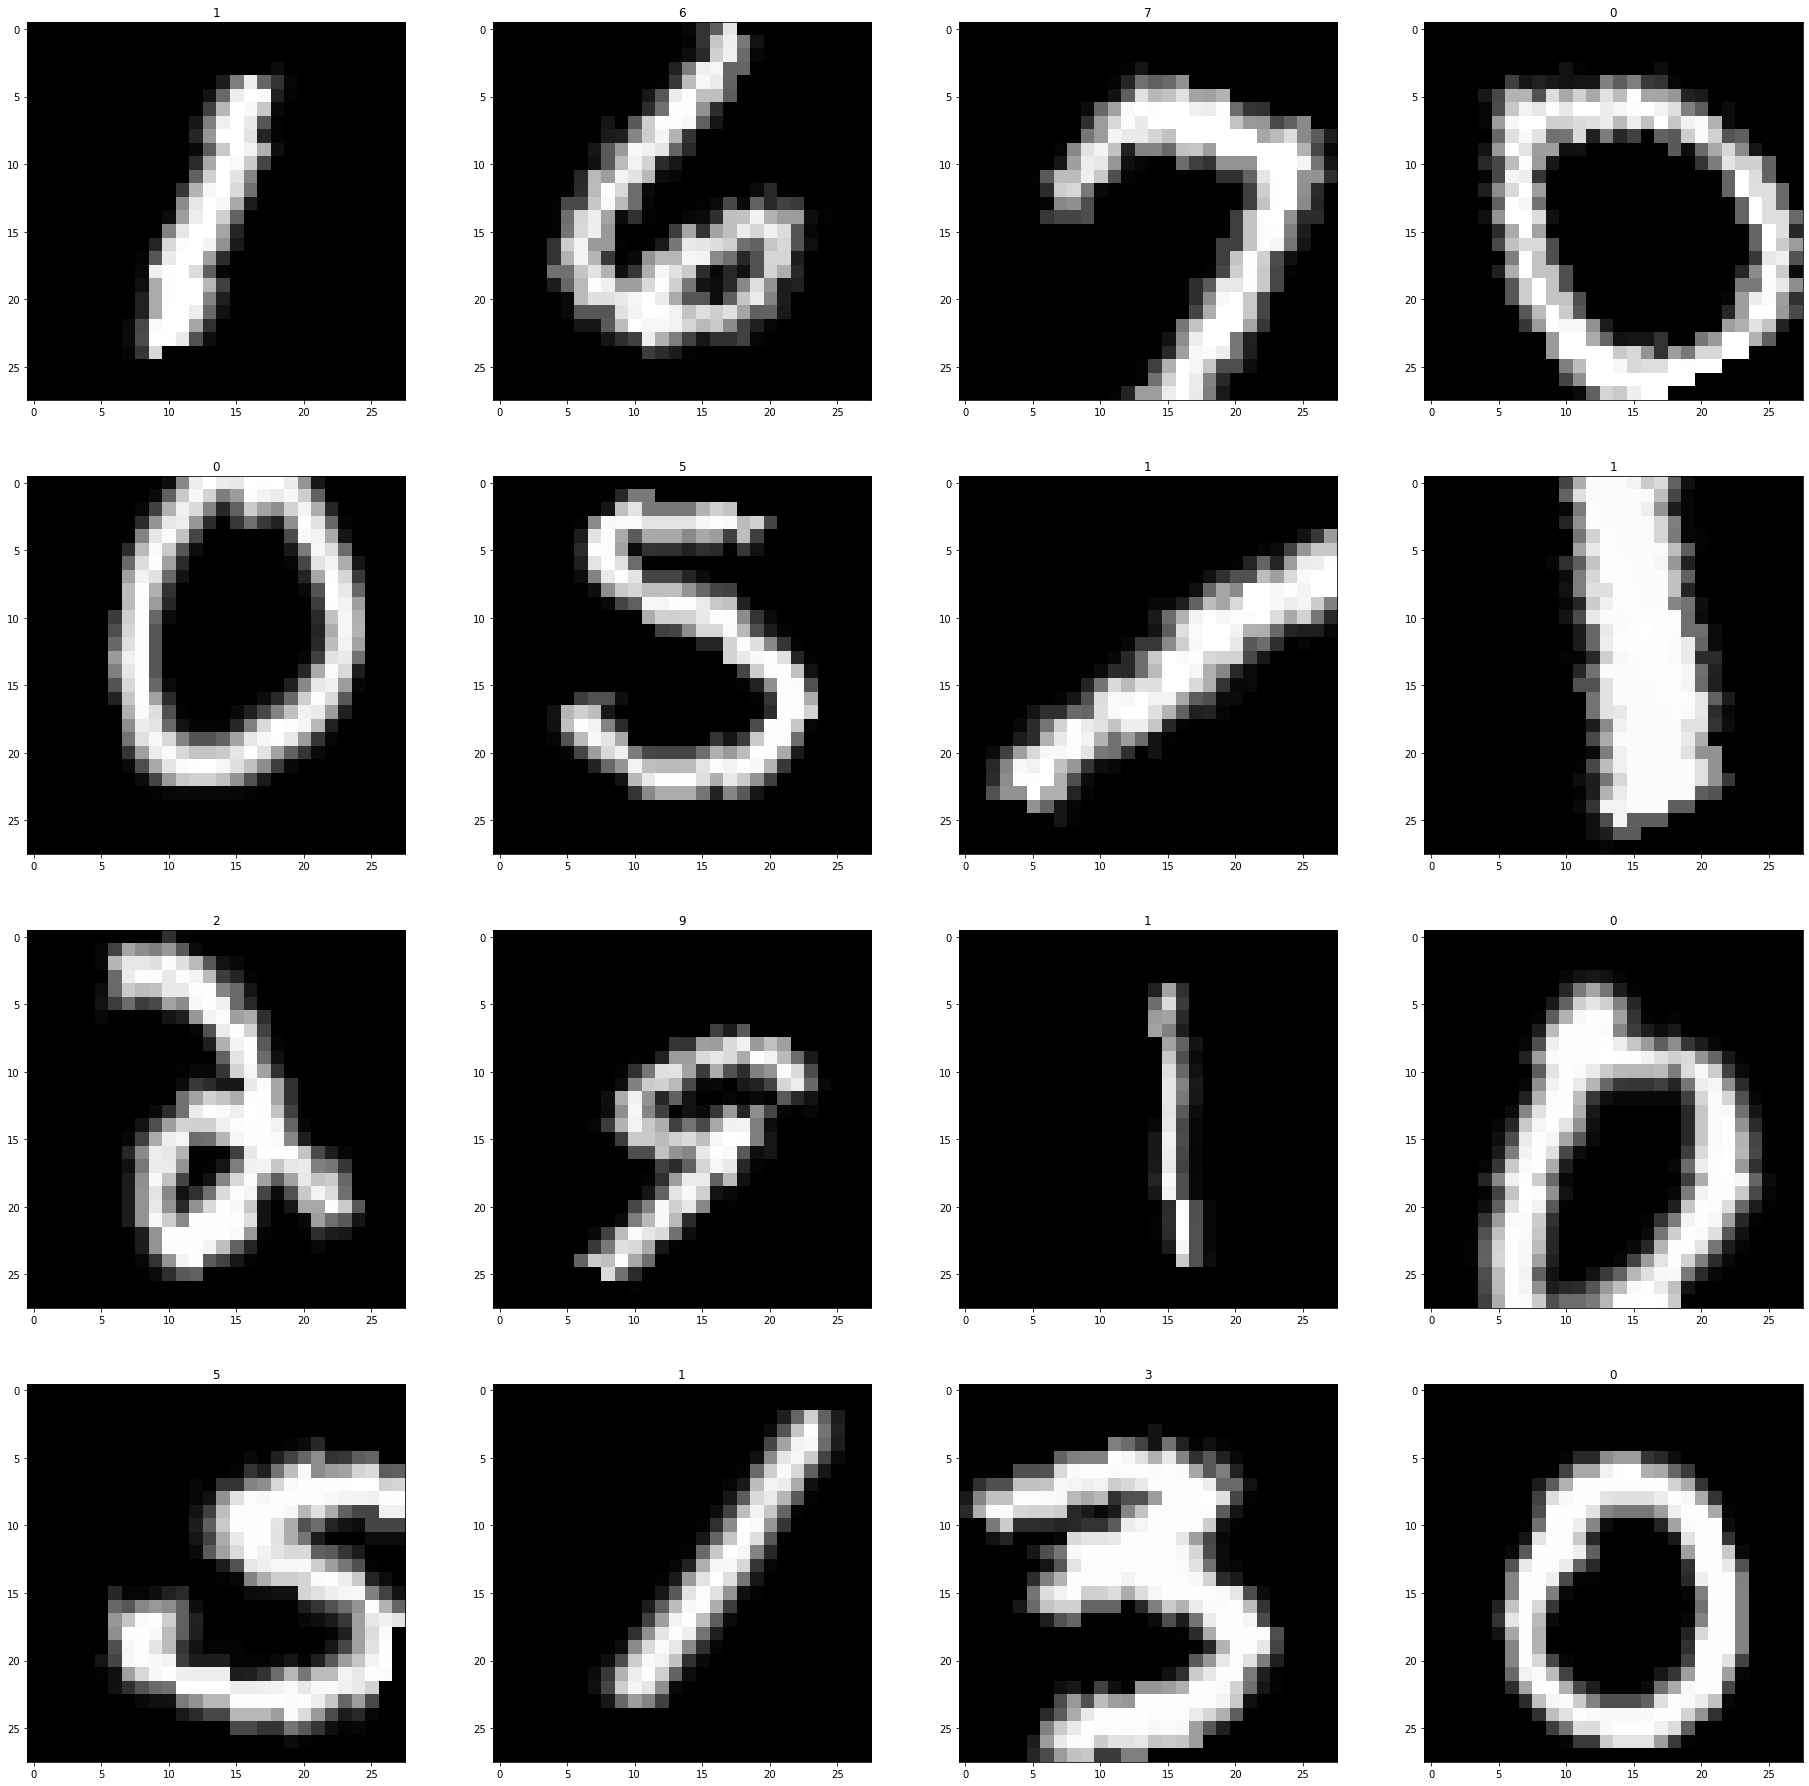

In [48]:
indices = np.random.randint(0, len(train_dataset), size=256)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(32, 32))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        sample_index = indices[i*4+j]
        sample, label = train_dataset[sample_index]
        ax.imshow(np.squeeze(sample.cpu().numpy().transpose(1, 2, 0)), cmap='gray')
        ax.set_title(label)

In [9]:
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 64,
                max_epochs = 1000,
                early_stopping_patience = 10):
    
    #region TENSORBOARD tutorial
    tb_writer = SummaryWriter(log_dir='./logs/run003/')
    #endregion ##############################
    
    #region borrowed from HW03
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    
    loss_history = []
    #endregion borrowed from HW03
    
    for epoch in range(max_epochs):
        #region borrowed from HW03
        print(f'Epoch {epoch}')
        train_epoch_loss_history = train_single_epoch(model,
                                                      optimizer,
                                                      loss_function,
                                                      train_loader,
                                                      tb_writer,
                                                      epoch,
                                                      batch_size=batch_size)
        loss_history = loss_history+train_epoch_loss_history
        val_metrics = validate_single_epoch(model, loss_function, val_loader)
        #endregion ##############################
        
        #region TENSORBOARD tutorial
        tb_writer.add_scalar('train_loss', np.sum(train_epoch_loss_history)/len(train_loader.dataset), global_step=epoch)
        tb_writer.add_scalar('val_loss', val_metrics['loss'], global_step=epoch)
        tb_writer.add_scalar('val_accuracy', val_metrics['accuracy'], global_step=epoch)
        #endregion ##############################
        
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

In [10]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001,
            max_epochs=100,
            batch_size=128)

Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.00it/s]


Validation metrics: 
{'loss': 0.003485710144042969, 'accuracy': 0.8892}
Best model yet, saving
Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.56it/s]


Validation metrics: 
{'loss': 0.002107677459716797, 'accuracy': 0.9242}
Best model yet, saving
Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.11it/s]


Validation metrics: 
{'loss': 0.001761519432067871, 'accuracy': 0.9342}
Best model yet, saving
Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.29it/s]


Validation metrics: 
{'loss': 0.0014597701072692872, 'accuracy': 0.9459}
Best model yet, saving
Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.08it/s]


Validation metrics: 
{'loss': 0.0012059850692749024, 'accuracy': 0.9561}
Best model yet, saving
Epoch 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.57it/s]


Validation metrics: 
{'loss': 0.0012620566368103027, 'accuracy': 0.9498}
Epoch 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.54it/s]


Validation metrics: 
{'loss': 0.0010866226196289063, 'accuracy': 0.959}
Best model yet, saving
Epoch 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.27it/s]


Validation metrics: 
{'loss': 0.0009626862525939941, 'accuracy': 0.9646}
Best model yet, saving
Epoch 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 69.33it/s]


Validation metrics: 
{'loss': 0.0008863312721252442, 'accuracy': 0.9679}
Best model yet, saving
Epoch 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.79it/s]


Validation metrics: 
{'loss': 0.0008051749229431152, 'accuracy': 0.9703}
Best model yet, saving
Epoch 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.69it/s]


Validation metrics: 
{'loss': 0.0007869598388671875, 'accuracy': 0.971}
Best model yet, saving
Epoch 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.20it/s]


Validation metrics: 
{'loss': 0.000691150426864624, 'accuracy': 0.9731}
Best model yet, saving
Epoch 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.24it/s]


Validation metrics: 
{'loss': 0.0007033073425292968, 'accuracy': 0.973}
Epoch 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.40it/s]


Validation metrics: 
{'loss': 0.0006787719249725342, 'accuracy': 0.9743}
Best model yet, saving
Epoch 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.66it/s]


Validation metrics: 
{'loss': 0.0007551558494567871, 'accuracy': 0.9705}
Epoch 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.67it/s]


Validation metrics: 
{'loss': 0.0006728914260864258, 'accuracy': 0.9752}
Best model yet, saving
Epoch 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.10it/s]


Validation metrics: 
{'loss': 0.000642230224609375, 'accuracy': 0.9758}
Best model yet, saving
Epoch 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.30it/s]


Validation metrics: 
{'loss': 0.0005793996334075927, 'accuracy': 0.9775}
Best model yet, saving
Epoch 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.84it/s]


Validation metrics: 
{'loss': 0.0005735031604766846, 'accuracy': 0.9776}
Best model yet, saving
Epoch 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 73.93it/s]


Validation metrics: 
{'loss': 0.0005334911823272706, 'accuracy': 0.9798}
Best model yet, saving
Epoch 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.25it/s]


Validation metrics: 
{'loss': 0.0005561714649200439, 'accuracy': 0.9776}
Epoch 21


 57%|█████████████████████████████████████████████████████████████▊                                               | 266/469 [00:08<00:06, 31.00it/s]


KeyboardInterrupt: 